In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from internal_cluster_analyze import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score

seed_value = 10
np.random.seed(seed_value)

# 3. Metodología

## 3.1. Descarga, presentación y descripción de los datos utilizados

In [2]:
df = pd.read_csv('Armado de bases\data_fundamental_fundamentalanalysis.csv')
df = df.pivot_table(index=['Ticker', 'Year'], columns='Variable')
df.columns = df.columns.get_level_values(1)
df = df[df.index.isin([2018, 2019, 2020, 2021, 2022], level=1)]
df_basics = pd.read_csv('Armado de bases\data_basic_finnhub.csv')

In [3]:
# Excluyo variables relacionadas con precio
df = df.drop(['ebtPerEbit', 'priceBookValueRatio',
       'priceCashFlowRatio', 'priceEarningsRatio',
       'priceEarningsToGrowthRatio', 'priceFairValue', 'priceSalesRatio',
       'priceToBookRatio', 'priceToFreeCashFlowsRatio',
       'priceToOperatingCashFlowsRatio', 'priceToSalesRatio'], axis=1)

# Excluyo variables relacionadas 1-1
df = df.drop(['cashFlowCoverageRatios', 'dividendPayoutRatio', 'ebitPerRevenue'], axis=1)

## 3.2. Preprocesamiento y limpieza de los datos

In [4]:
# Verifico nulos por columna
df.isnull().sum()[df.isnull().sum() > 0]

Variable
cashConversionCycle           288
cashPerShare                    1
cashRatio                       1
daysOfInventoryOutstanding      1
daysOfPayablesOutstanding       1
daysOfSalesOutstanding          1
enterpriseValueMultiple         1
inventoryTurnover               5
operatingCycle                288
quickRatio                      1
shortTermCoverageRatios         1
totalDebtToCapitalization       1
dtype: int64

In [5]:
# Tratamiento de los nulos
df.drop(('GEN', 2018), inplace=True)
df.drop(('OGN', 2018), inplace=True)
df.drop(('HBAN', 2022), inplace=True)
df['inventoryTurnover'].fillna(0, inplace=True)

base = pd.DataFrame()
for year in [2018, 2019, 2020, 2021, 2022]:
    df_year = df[df.index.isin([year], level=1)].copy()
    ccc_median = df_year.cashConversionCycle.median()
    oc_median = df_year.operatingCycle.median()
    print(year, ccc_median, oc_median)
    df_year['cashConversionCycle'].fillna(ccc_median, inplace=True)
    df_year['operatingCycle'].fillna(oc_median, inplace=True)
    base = pd.concat([base, df_year])

df = base.copy()

2018 41.85316436592817 99.78532123056806
2019 40.04787137613025 99.75992225741744
2020 42.848837901119346 103.80413896379973
2021 43.086183202839564 104.03673731680118
2022 41.38687007450746 103.28209453512709


## 3.3. Análisis exploratorio de datos

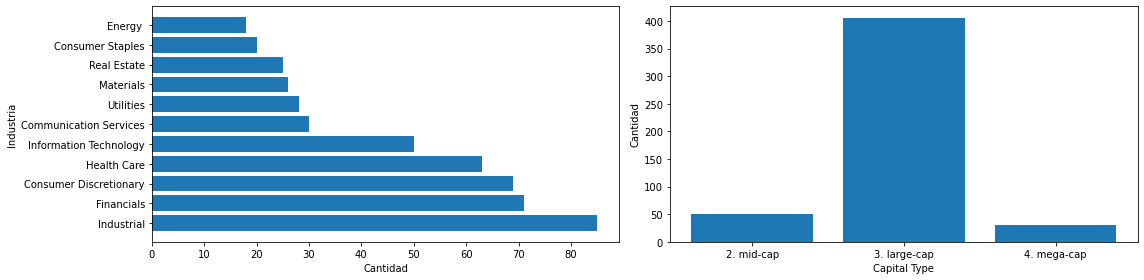

In [6]:
df_basics['mkt_years'] = np.floor(((pd.Timestamp('today').normalize() - pd.to_datetime(df_basics['ipo_date'])).dt.days)/365)

def reducir_categorias(df):
    df['mkt_industry'] = df['industry'].replace({
        'Life Sciences Tools & Services': 'Health Care',
        'Retail': 'Consumer Discretionary',
        'Technology': 'Information Technology',
        'Biotechnology': 'Health Care',
        'Health Care': 'Health Care',
        'Semiconductors': 'Information Technology',
        'Professional Services': 'Industrial',
        'Utilities': 'Utilities',
        'Insurance': 'Financials',
        'Chemicals': 'Materials',
        'Building': 'Industrial',
        'Packaging': 'Materials',
        'Electrical Equipment': 'Industrial',
        'Real Estate': 'Real Estate',
        'Communications': 'Communication Services',
        'Energy': 'Energy',
        'Auto Components': 'Consumer Discretionary',
        'Media': 'Communication Services',
        'Banking': 'Financials',
        'Financial Services': 'Financials',
        'Pharmaceuticals': 'Health Care',
        'Food Products': 'Consumer Staples',
        'Machinery': 'Industrial',
        'Hotels, Restaurants & Leisure': 'Consumer Discretionary',
        'Consumer products': 'Consumer Discretionary',
        'Logistics & Transportation': 'Industrial',
        'Commercial Services & Supplies': 'Industrial',
        'Road & Rail': 'Industrial',
        'Airlines': 'Industrial',
        'Automobiles': 'Consumer Discretionary',
        'Trading Companies & Distributors': 'Industrial',
        'Metals & Mining': 'Materials',
        'Aerospace & Defense': 'Industrial',
        'Industrial Conglomerates': 'Industrial',
        'Distributors': 'Industrial',
        'Leisure Products': 'Consumer Discretionary',
        'Beverages': 'Consumer Staples',
        'Telecommunication': 'Communication Services',
        'Construction': 'Industrial',
        'Tobacco': 'Consumer Staples',
        'Textiles, Apparel & Luxury Goods': 'Consumer Discretionary'
    })
    return df

df_basics = reducir_categorias(df_basics)
df_basics['mkt_cap_type'] = np.where(df_basics['mkt_cap'] < 2000, '1. small-cap', 
    np.where(df_basics['mkt_cap'] < 10000, '2. mid-cap', 
    np.where(df_basics['mkt_cap'] < 200000, '3. large-cap', '4. mega-cap')))

df_basics_describe = df_basics[df_basics.symbol.isin(df.index.get_level_values(0))]
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
mkt_industry_counts = df_basics_describe['mkt_industry'].value_counts()
axes[0].barh(mkt_industry_counts.index, mkt_industry_counts.values)
axes[0].set_xlabel('Cantidad')
axes[0].set_ylabel('Industria')
#axes[1].hist(df_basics_describe['mkt_years'], bins=5)
#axes[1].set_xlabel('Años de antigüedad')
#axes[1].set_ylabel('Cantidad')

cap_type_counts = df_basics_describe['mkt_cap_type'].value_counts()
df_cap_type_counts = pd.DataFrame({'Cap Type': cap_type_counts.index, 'Count': cap_type_counts.values})
df_cap_type_counts_sorted = df_cap_type_counts.sort_values(by='Cap Type')
#axes[2].bar(cap_type_counts.index, cap_type_counts.values)
axes[1].bar(df_cap_type_counts_sorted['Cap Type'], df_cap_type_counts_sorted['Count'])
axes[1].set_xlabel('Capital Type')
axes[1].set_ylabel('Cantidad')
plt.tight_layout()

# Mostrar la figura
plt.show()

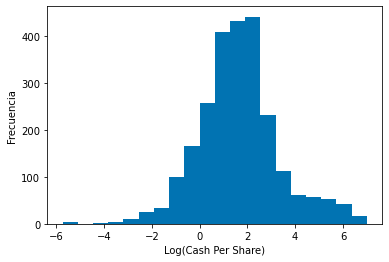

In [7]:
# Evaluación de outliers
valid_values = df['cashPerShare'].loc[df['cashPerShare'] > 0]
log_values = np.log(valid_values)
sns.set_palette("colorblind")
plt.hist(log_values, bins=20)
plt.xlabel('Log(Cash Per Share)')
plt.ylabel('Frecuencia')
plt.show()

In [8]:
def z_score_median(column):
    median = np.median(column)
    mad = np.median(np.abs(column - median))
    z_scores = 0.6745 * (column - median) / mad
    return z_scores

outliers_proportion_df = pd.DataFrame(columns=['Columna', 'Proporcion_Outliers'])

for column in df.columns:
    z_scores = z_score_median(df[column])
    outliers_proportion = np.mean(np.abs(z_scores) > 3)
    outliers_proportion_df = outliers_proportion_df.append({'Columna': column, 'Proporcion_Outliers': outliers_proportion}, ignore_index=True)
    
outliers_proportion_df.sort_values(by='Proporcion_Outliers', ascending=False).head(20)

df = df[list(outliers_proportion_df[outliers_proportion_df.Proporcion_Outliers < 0.1]['Columna'])]
def z_score(column):
    mean = np.mean(column)
    std = np.std(column)
    z_scores = (column - mean) / std
    return z_scores

outliers_mask = np.abs(z_score(df)) > 3
df = df[~outliers_mask.any(axis=1)]
df.shape

(2299, 23)

## 3.4. Selección de variables

<AxesSubplot:xlabel='Variable', ylabel='Variable'>

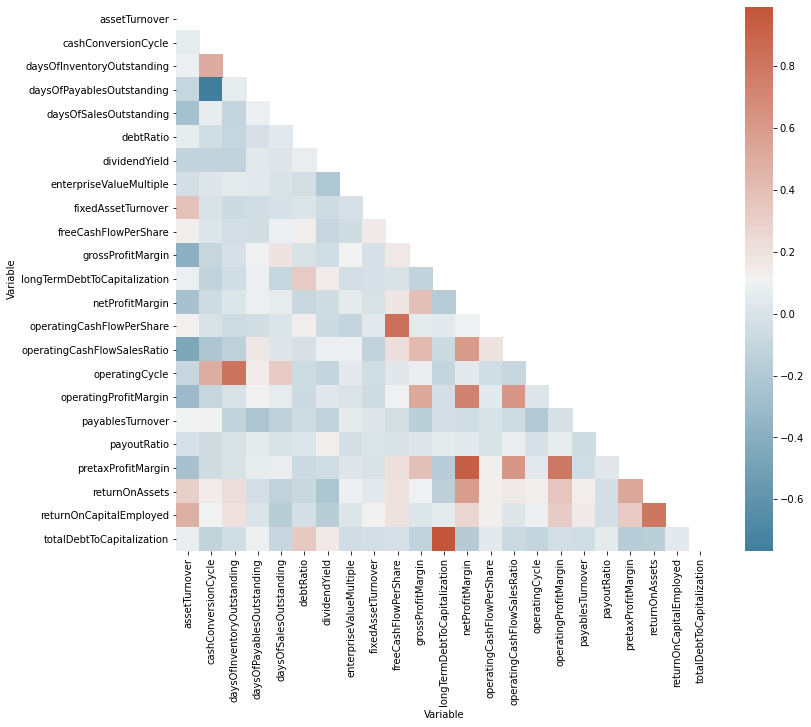

In [9]:
corr = df.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap)

In [10]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, minimas=False):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=minimas)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 50, minimas=False))


Top Absolute Correlations
Variable                      Variable                    
longTermDebtToCapitalization  totalDebtToCapitalization       0.991618
netProfitMargin               pretaxProfitMargin              0.935117
freeCashFlowPerShare          operatingCashFlowPerShare       0.828896
daysOfInventoryOutstanding    operatingCycle                  0.819355
returnOnAssets                returnOnCapitalEmployed         0.802691
operatingProfitMargin         pretaxProfitMargin              0.793960
cashConversionCycle           daysOfPayablesOutstanding       0.766263
netProfitMargin               operatingProfitMargin           0.734095
operatingCashFlowSalesRatio   operatingProfitMargin           0.620813
                              pretaxProfitMargin              0.620055
netProfitMargin               operatingCashFlowSalesRatio     0.598825
                              returnOnAssets                  0.581500
pretaxProfitMargin            returnOnAssets                  0

In [11]:
df = df.drop(['longTermDebtToCapitalization', 'netProfitMargin', 'pretaxProfitMargin', 'freeCashFlowPerShare', 'cashConversionCycle', 'operatingCycle'], axis=1).reset_index()

## 3.5. Creación de variables

0.26190478795595157


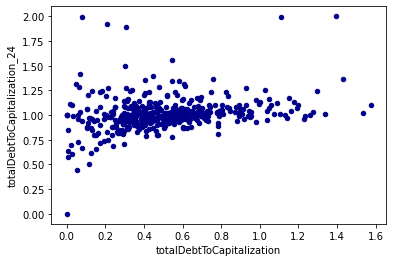

In [12]:
df22 = pd.DataFrame()

for ticker in df.Ticker.unique():
    df_ticker = df[df.Ticker == ticker].copy()
    for col in df_ticker.columns[2:]:
        str_24 = col + '_24'
        df_ticker[str_24] = df_ticker[col].rolling(2, min_periods=1).mean() / df_ticker[col].rolling(4, min_periods=1).mean()
        df_ticker[str_24] = df_ticker[str_24].fillna(1)
    df22 = pd.concat([df22, df_ticker[df_ticker.Year == 2022]])
    
df22.plot.scatter(x='totalDebtToCapitalization', y='totalDebtToCapitalization_24', c='DarkBlue')
print(df22['totalDebtToCapitalization'].corr(df22['totalDebtToCapitalization_24']))

# 4. Resultados

## 4.1. Análisis de componentes principales

In [13]:
scaler = MinMaxScaler()
scaler.fit(df22.iloc[:, 2:])
X_std = scaler.transform(df22.iloc[:, 2:])

pca = PCA(n_components=2)
columnas = df22.iloc[:, 2:].columns[~df22.iloc[:, 2:].columns.str.contains('cluster')]
principal_components = pca.fit_transform(pd.DataFrame(X_std, columns=columnas))
df_pca = pd.DataFrame(data=principal_components, columns=['Componente 1', 'Componente 2'])
component_importance = pd.DataFrame(pca.components_.T, columns=['Componente 1', 'Componente 2'], index=columnas)

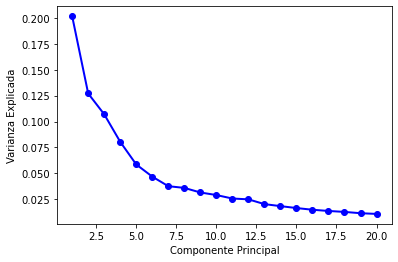

In [14]:
pca_viz = PCA(n_components=20) #
principal_components_viz = pca_viz.fit_transform(pd.DataFrame(X_std, columns=columnas))
varianza_explicada = pca_viz.explained_variance_ratio_
num_componentes = len(varianza_explicada)
indices = np.arange(1, num_componentes + 1)
plt.plot(indices, varianza_explicada, 'bo-', linewidth=2)
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.show()


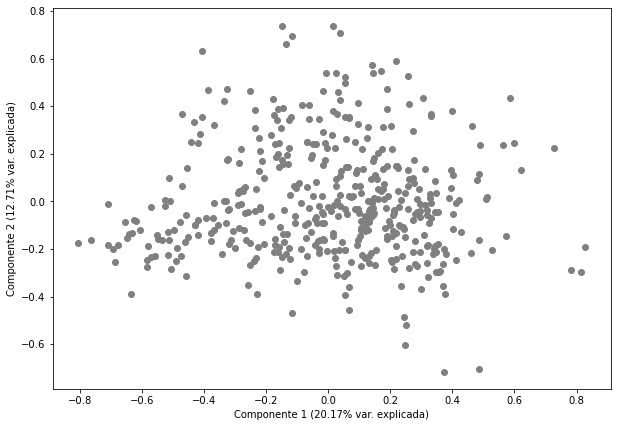

In [15]:
index_names = df22['Ticker']
fig, ax = plt.subplots(figsize =(10, 7))
ax.scatter(df_pca.loc[:, 'Componente 1'], df_pca.loc[:, 'Componente 2'], c='grey')
ax.set_xlabel(f'Componente 1 ({pca.explained_variance_ratio_[0]*100:.2f}% var. explicada)')
ax.set_ylabel(f'Componente 2 ({pca.explained_variance_ratio_[1]*100:.2f}% var. explicada)')
plt.show()

In [16]:
component_importance['diff'] = component_importance['Componente 1'] - component_importance['Componente 2']
component_importance.sort_values(by='diff')

,Componente 1,Componente 2,diff
Variable,,,
grossProfitMargin,-0.807193,0.165458,-0.972651
operatingCashFlowSalesRatio,-0.299085,0.093015,-0.392101
operatingProfitMargin,-0.181542,0.198445,-0.379987
daysOfInventoryOutstanding,0.130535,0.500217,-0.369682
returnOnAssets,0.063024,0.429608,-0.366584
returnOnCapitalEmployed,0.162833,0.526859,-0.364027
dividendYield_24,-0.060839,0.093061,-0.153900
daysOfSalesOutstanding,-0.168465,-0.072927,-0.095538
operatingCashFlowPerShare,-0.030983,0.060340,-0.091323


## 4.2. K-Means

### Determinación de la cantidad de clusters

C:\Users\ffliguer\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


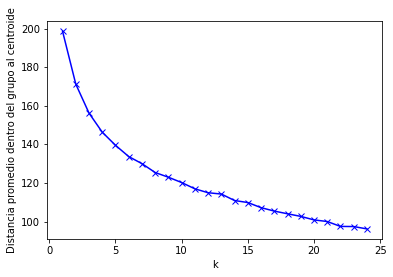

In [17]:
seed_value = 10000
np.random.seed(seed_value)

Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_std)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Distancia promedio dentro del grupo al centroide')
plt.show()

### Armado de clusters y resultados

In [18]:
km_model = KMeans(n_clusters=6).fit(X_std)
df22['kmeans_cluster'] = km_model.predict(X_std)

# Coeficiente de silueta
km_silhouette_avg = silhouette_score(X_std, df22['kmeans_cluster'])
print("Coeficiente de silueta:", km_silhouette_avg)

# Índice de Calinski-Harabasz
km_ch_score = calinski_harabasz_score(X_std, df22['kmeans_cluster'])
print("Índice de Calinski-Harabasz:", km_ch_score)


Coeficiente de silueta: 0.12485683830337846
Índice de Calinski-Harabasz: 42.68958859790458


### Visualización de la clusterización

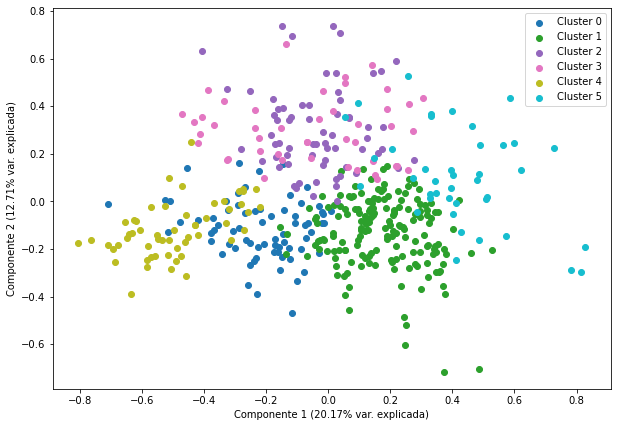

In [19]:
index_names = df22['Ticker']
fig, ax = plt.subplots(figsize =(10, 7))
unique_labels = np.unique(df22['kmeans_cluster'])
colors = plt.cm.get_cmap('tab10', len(unique_labels))
for i, label in enumerate(unique_labels):
    cluster_indices = np.where(df22['kmeans_cluster'] == label)[0]
    ax.scatter(df_pca.loc[cluster_indices, 'Componente 1'], df_pca.loc[cluster_indices, 'Componente 2'],
               c=[colors(i)], label=f'Cluster {label}')
ax.legend()
ax.set_xlabel(f'Componente 1 ({pca.explained_variance_ratio_[0]*100:.2f}% var. explicada)')
ax.set_ylabel(f'Componente 2 ({pca.explained_variance_ratio_[1]*100:.2f}% var. explicada)')
plt.show()

## 4.3. Aglomerativo

### Visualizo dendrograma

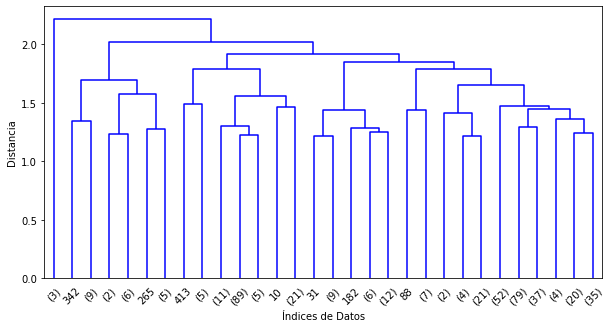

In [20]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage

def color_func(*args):
    return 'blue'


columna_especifica = df22.loc[:, 'Ticker']

Z = linkage(X_std, method='complete')
plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z, 
                     truncate_mode='lastp', 
                     p=30, 
                     show_leaf_counts=True, 
                     color_threshold=float('inf'), 
                     link_color_func=color_func
                    )

plt.xlabel('Índices de Datos')
plt.ylabel('Distancia')
plt.show()



### Armado de clusters y resultados

In [21]:
from sklearn.cluster import AgglomerativeClustering
aggcl = AgglomerativeClustering(distance_threshold=1.8, n_clusters=None,linkage = 'complete', compute_distances = True)
aggcl.fit(X_std)
df22['agg_cluster'] = aggcl.labels_

# Coeficiente de silueta
agg_silhouette_avg = silhouette_score(X_std, df22['agg_cluster'])
print("Coeficiente de silueta:", agg_silhouette_avg)

# Índice de Calinski-Harabasz
agg_ch_score = calinski_harabasz_score(X_std, df22['agg_cluster'])
print("Índice de Calinski-Harabasz:", agg_ch_score)


Coeficiente de silueta: 0.0599138262200837
Índice de Calinski-Harabasz: 24.733955769243597


### Visualización de la clusterización

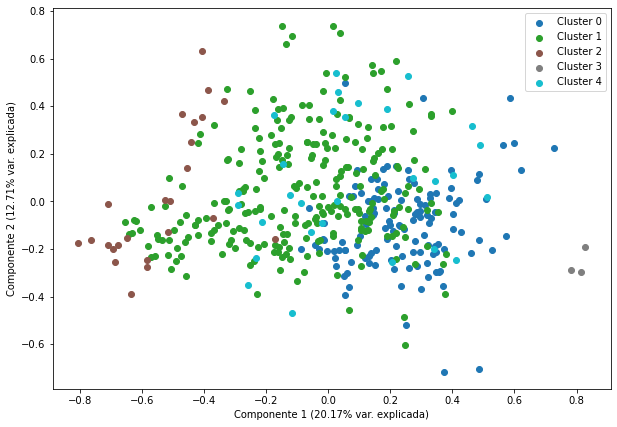

In [22]:
index_names = df22['Ticker']
fig, ax = plt.subplots(figsize =(10, 7))
unique_labels = np.unique(df22['agg_cluster'])
colors = plt.cm.get_cmap('tab10', len(unique_labels))
for i, label in enumerate(unique_labels):
    cluster_indices = np.where(df22['agg_cluster'] == label)[0]
    ax.scatter(df_pca.loc[cluster_indices, 'Componente 1'], df_pca.loc[cluster_indices, 'Componente 2'],
               c=[colors(i)], label=f'Cluster {label}')
ax.legend()
ax.set_xlabel(f'Componente 1 ({pca.explained_variance_ratio_[0]*100:.2f}% var. explicada)')
ax.set_ylabel(f'Componente 2 ({pca.explained_variance_ratio_[1]*100:.2f}% var. explicada)')
plt.show()


## 4.4. DBSCAN

In [23]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Crear el objeto DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_std)
df22['dbscan_cluster'] = dbscan_labels

# Coeficiente de silueta
dbscan_silhouette_avg = silhouette_score(X_std, df22['dbscan_cluster'])
print("Coeficiente de silueta:", dbscan_silhouette_avg)

# Índice de Calinski-Harabasz
dbscan_ch_score = calinski_harabasz_score(X_std, df22['dbscan_cluster'])
print("Índice de Calinski-Harabasz:", dbscan_ch_score)

Coeficiente de silueta: 0.18671383484552226
Índice de Calinski-Harabasz: 9.769973698265918


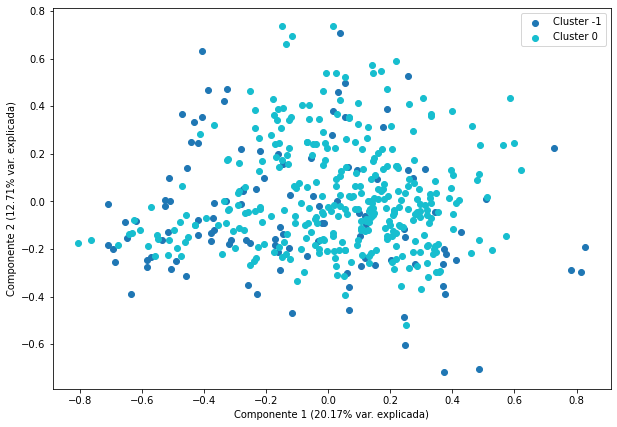

In [24]:
index_names = df22['Ticker']
fig, ax = plt.subplots(figsize =(10, 7))
unique_labels = np.unique(df22['dbscan_cluster'])
colors = plt.cm.get_cmap('tab10', len(unique_labels))
for i, label in enumerate(unique_labels):
    cluster_indices = np.where(df22['dbscan_cluster'] == label)[0]
    ax.scatter(df_pca.loc[cluster_indices, 'Componente 1'], df_pca.loc[cluster_indices, 'Componente 2'],
               c=[colors(i)], label=f'Cluster {label}')
ax.legend()
ax.set_xlabel(f'Componente 1 ({pca.explained_variance_ratio_[0]*100:.2f}% var. explicada)')
ax.set_ylabel(f'Componente 2 ({pca.explained_variance_ratio_[1]*100:.2f}% var. explicada)')
plt.show()
component_importance = pd.DataFrame(pca.components_.T, columns=['Componente 1', 'Componente 2'], index=columnas)


## 4.4. Evaluación externa

In [25]:
df_clustered_basics = pd.merge(df22, df_basics, left_on='Ticker', right_on='symbol', how='inner').dropna()
cluster_comparition = pd.DataFrame(columns = ['algoritmo', 'numero_clusters', 'silueta', 'calinski_harabasz', 'ari_industrias', 'ari_tamaños'])
cluster_comparition.loc[len(cluster_comparition)] = ['kmeans',len(df_clustered_basics.groupby('kmeans_cluster').size()),km_silhouette_avg,km_ch_score,adjusted_rand_score(df_clustered_basics['mkt_industry'], df_clustered_basics['kmeans_cluster']),adjusted_rand_score(df_clustered_basics['mkt_cap_type'], df_clustered_basics['kmeans_cluster'])]
cluster_comparition.loc[len(cluster_comparition)] = ['agglomerative',len(df_clustered_basics.groupby('agg_cluster').size()),agg_silhouette_avg,agg_ch_score,adjusted_rand_score(df_clustered_basics['mkt_industry'], df_clustered_basics['agg_cluster']),adjusted_rand_score(df_clustered_basics['mkt_cap_type'], df_clustered_basics['agg_cluster'])]
cluster_comparition.loc[len(cluster_comparition)] = ['dbscan',len(df_clustered_basics.groupby('dbscan_cluster').size()),dbscan_silhouette_avg,dbscan_ch_score,adjusted_rand_score(df_clustered_basics['mkt_industry'], df_clustered_basics['dbscan_cluster']),adjusted_rand_score(df_clustered_basics['mkt_cap_type'], df_clustered_basics['dbscan_cluster'])]
cluster_comparition.T

,0,1,2
algoritmo,kmeans,agglomerative,dbscan
numero_clusters,6,5,2
silueta,0.124857,0.0599138,0.186714
calinski_harabasz,42.6896,24.734,9.76997
ari_industrias,0.101234,0.0276634,0.011124
ari_tamaños,0.0129527,-0.0262167,-0.0157155


### Clusters e industria de la empresa

<Figure size 720x432 with 0 Axes>

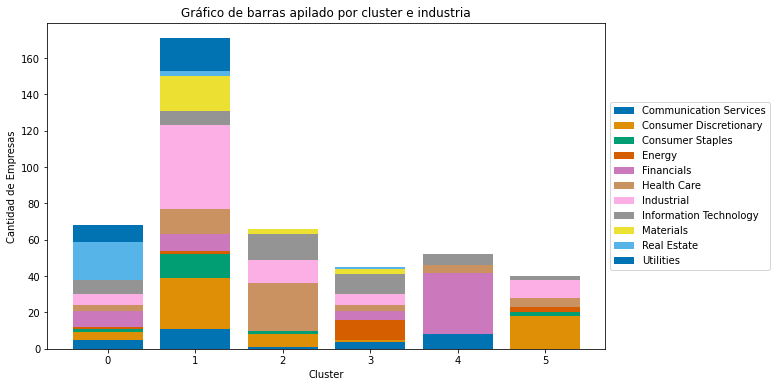

mkt_industry,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrial,Information Technology,Materials,Real Estate,Utilities
kmeans_cluster,,,,,,,,,,,
0,5,4,2,1,9,3,6,8,0,21,9
1,11,28,13,2,9,14,46,8,19,3,18
2,1,7,2,0,0,26,13,14,3,0,0
3,4,1,0,11,5,3,6,11,3,1,0
4,8,0,0,0,34,4,0,6,0,0,0
5,0,18,2,3,0,5,10,2,0,0,0


In [26]:
plt.figure(figsize=(10, 6))

cross_tab = pd.crosstab(df_clustered_basics['kmeans_cluster'], df_clustered_basics['mkt_industry'])
stacked_data = cross_tab.stack().reset_index().rename(columns={0: 'Cantidad de empresas'})
stacked_data

grouped = stacked_data.groupby(['kmeans_cluster', 'mkt_industry'])['Cantidad de empresas'].sum().unstack()
fig, ax = plt.subplots(figsize=(10, 6))

clusters = grouped.index
industrias = grouped.columns
bottom = None

for ind in industrias:
    valores = grouped[ind].values
    if bottom is None:
        ax.bar(clusters, valores, label=ind)
        bottom = valores
    else:
        ax.bar(clusters, valores, bottom=bottom, label=ind)
        bottom += valores

ax.set_xlabel('Cluster')
ax.set_ylabel('Cantidad de Empresas')
ax.set_title('Gráfico de barras apilado por cluster e industria')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
cross_tab

## 6. Anexo

### Agrego enfoque de selección de portafolios

In [27]:
import yfinance as yf
from pypfopt import expected_returns
from pypfopt import risk_models
import random

def return_fn(prices, resample_freq=None, type="log", since=None):
    if since is None:
        prices_ = prices
    else:
        prices_ = prices.loc[since:]
    
    if resample_freq is not None:
        prices_ = prices_.asfreq(resample_freq).ffill()
        #(resample_freq).last()
    
    if type == 'log':
        returns = prices_.apply(np.log).diff()
    else:
        returns = prices_.pct_change()
    
    returns.dropna(inplace = True)
    return returns

def mean_var_estimates(returns, freq = None):
    if freq is not None:
        mean_estimate = np.expm1(returns.mean()*freq)
        cov_estimate = returns.cov()*freq
    else:
        mean_estimate = np.expm1(returns.mean())
        cov_estimate = returns.cov()
    return mean_estimate, cov_estimate
        

In [35]:
df_portfolio_selection = df_clustered_basics[['Ticker', 'mkt_industry', 'kmeans_cluster']]
prices = yf.download(list(df_clustered_basics.Ticker.unique()), start='2022-10-31', end='2023-06-30')['Adj Close'].iloc[1:, :].dropna(axis=1, how='any')
returns = return_fn(prices, resample_freq='BM', type = 'discrete')
monthly_prices = prices.asfreq('BM').ffill()
monthly_returns = monthly_prices.pct_change()
mu = expected_returns.mean_historical_return(monthly_prices,frequency=12)
covmat = risk_models.sample_cov(monthly_prices, frequency = 12)
sd = np.sqrt(np.diag(covmat))
df_sample = pd.DataFrame()
df_sample['Mu'] = mean_var_estimates(returns = monthly_returns, freq = 12)[0]
df_sample['Sigma'] = np.sqrt(np.diag(mean_var_estimates(returns = monthly_returns, freq = 12)[1]))
cov_matrix = mean_var_estimates(returns = monthly_returns, freq = 12)[1]

[*********************100%***********************]  442 of 442 completed

1 Failed download:
- FRC: No data found, symbol may be delisted


C:\Users\ffliguer\Anaconda3\lib\site-packages\pypfopt\risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
C:\Users\ffliguer\Anaconda3\lib\site-packages\pypfopt\risk_models.py:87: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


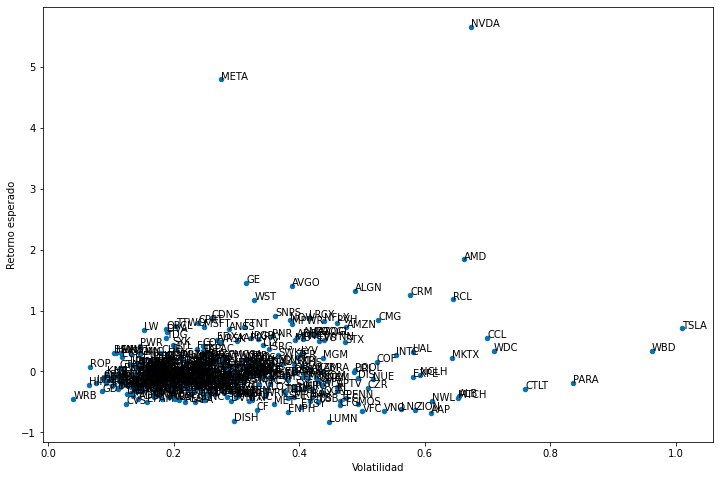

In [38]:
fig, ax = plt.subplots(figsize = (12,8))
df_sample.plot(x='Sigma', y = 'Mu', kind = 'scatter', ax = ax)
plt.ylabel('Retorno esperado')
plt.xlabel('Volatilidad')

for k, v in df_sample.iterrows():
    ax.annotate(k,v[::-1])

In [29]:
def port_var(weights, covariance_matrix):
    return weights.T @ covariance_matrix @ weights

def port_mean(weights, mean_returns):
    return mean_returns @ weights

def portfolio_metrics(weights, mean_returns, cov_matrix):
    ret = port_mean(weights=weights, mean_returns= mean_returns)
    std = np.sqrt(port_var(weights=weights, covariance_matrix=cov_matrix))
    return ret, std

def random_portfolios(num_port, mean_returns, cov_matrix, num_max_assets = 6, df_basics = None, restriccion = None):
    mu_list = []
    std_list = []
    
    mkt_industries = df_basics['mkt_industry'].unique()
    mkt_clusters = df_basics['kmeans_cluster'].unique()
    
    j = 0
    while j <= num_port:
        num_selected_assets = 6 # np.random.randint(num_max_assets, num_max_assets + 1)
        if restriccion is None:
            selected_assets = df_basics['Ticker'].sample(num_selected_assets).values
            j = j + 1
                        
        if restriccion == 'industries':
            selected_assets = df_basics.groupby('mkt_industry').sample(n = 1)['Ticker'].sample(num_selected_assets).values            
            j = j + 1
            
        if restriccion == 'clusters':            
            selected_assets = df_basics.groupby('kmeans_cluster').sample(n = 1)['Ticker'].sample(num_selected_assets).values
            j = j + 1
            
        if restriccion == 'industries_clusters': 
            df_posible_assets = df_basics[df_basics.Ticker.isin(df_basics.groupby('mkt_industry').sample(n = 1)['Ticker'].values)]
            if len(df_posible_assets.kmeans_cluster.unique()) < num_selected_assets:
                j = j
                continue
            else:
                selected_assets = df_posible_assets.groupby('kmeans_cluster').sample(n = 1)['Ticker'].sample(num_selected_assets).values
                j = j + 1
            
        mean_returns_selected_assets = mean_returns[selected_assets]
        cov_matrix_selected_assets = cov_matrix.loc[selected_assets, selected_assets]

        weights = np.random.rand(len(mean_returns_selected_assets))
        weights /= np.sum(weights)
        port_mu, port_std = portfolio_metrics(weights, mean_returns_selected_assets, cov_matrix_selected_assets)
        mu_list.append(port_mu)
        std_list.append(port_std)
        
    return mu_list, std_list

In [30]:
n_port = 1000
print('Portafolios sin restricción')
mu_none, std_none = random_portfolios(n_port, df_sample['Mu'], cov_matrix, df_basics = df_portfolio_selection[df_portfolio_selection.Ticker.isin(df_sample.index)], restriccion = None)

print('Portafolios sin repetir industrias')
mu_ind, std_ind = random_portfolios(n_port, df_sample['Mu'], cov_matrix, df_basics = df_portfolio_selection[df_portfolio_selection.Ticker.isin(df_sample.index)], restriccion = 'industries')

print('Portafolios sin repetir clusters')
mu_cl, std_cl = random_portfolios(n_port, df_sample['Mu'], cov_matrix, df_basics = df_portfolio_selection[df_portfolio_selection.Ticker.isin(df_sample.index)], restriccion = 'clusters')

#print('Portafolios sin repetir industrias ni clusters')
#mu_indcl, std_indcl = random_portfolios(n_port, df_sample['Mu'], cov_matrix, df_basics = df_portfolio_selection[df_portfolio_selection.Ticker.isin(df_sample.index)], restriccion = 'industries_clusters')

Portafolios sin restricción
Portafolios sin repetir industrias
Portafolios sin repetir clusters


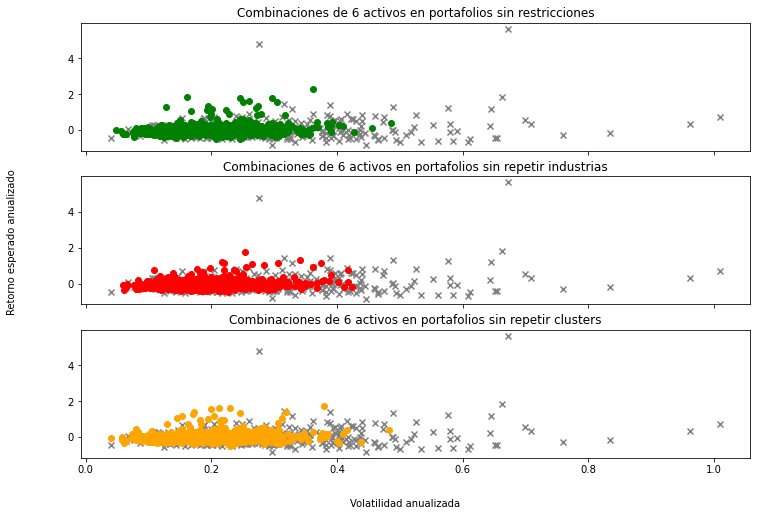

In [61]:
fig, axs = plt.subplots(3, figsize=(12, 8), sharex=True)
fig.text(0.5, 0.04, 'Volatilidad anualizada', ha='center')
fig.text(0.04, 0.5, 'Retorno esperado anualizado', va='center', rotation='vertical')

axs[0].scatter(df_sample['Sigma'], df_sample['Mu'], marker = 'x', color = 'grey')
axs[0].plot(std_none, mu_none, 'o', color='green')
axs[0].set_title('Combinaciones de 6 activos en portafolios sin restricciones')

axs[1].scatter(df_sample['Sigma'], df_sample['Mu'], marker = 'x', color = 'grey')
axs[1].plot(std_ind, mu_ind, 'o', color='red')
axs[1].set_title('Combinaciones de 6 activos en portafolios sin repetir industrias')

axs[2].scatter(df_sample['Sigma'], df_sample['Mu'], marker = 'x', color = 'grey')
axs[2].plot(std_cl, mu_cl, 'o', color='orange')
axs[2].set_title('Combinaciones de 6 activos en portafolios sin repetir clusters')
plt.show()
